<a href="https://colab.research.google.com/github/LaryssaF/IA/blob/main/IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Análise de dados do Ultimate Fighter Championship

* Projeto de Inteligência Artificial

O Ultimate Fighter Championship (UFC) é uma promoção americana de artes marciais mistas na fronteira do esporte. Desde 1993, o UFC sediou mais de 500 eventos, cada um com até 20 lutas. As lutas são feitas e anunciadas por casamenteiros e os lutadores são todos membros do elenco do UFC. No elenco, há 8 classes de peso para homens e 4 classes de peso para mulheres, cada classe de peso consistindo de aproximadamente 50 lutadores. Os lutadores contratados pelo UFC geralmente fizeram seu nome em outros esportes de combate ou são prospectos de elite de promoções menores ou regionais de MMA, então o UFC tem sido capaz de se gabar do melhor dos melhores durante sua existência.

O objetivo dessa analise é explorar tendências nos dados do UFC com base em dados logísticos e estatísticas de lutas, aprender quais lutadores são os melhores e tentar prever o resultado das lutas com base em dados históricos dos lutadores.

In [ ]:
!pip install pandas scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df_raw = pd.read_csv("/content/drive/MyDrive/IA/base de dados/data.csv")
df_raw.head()

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/IA/base de dados/preprocessed_data.csv")
df.head()

In [ ]:
df.describe()

In [ ]:
print("colunas: ", df.shape[1])
print("linhas: ", df.shape[0])

colunas = df.shape[1]

colunas:  160
linhas:  3592


In [ ]:
print(df.dtypes)

Winner                    object
title_bout                  bool
no_of_rounds               int64
B_current_lose_streak    float64
B_current_win_streak     float64
                          ...   
B_Stance_Switch            int64
R_Stance_Open Stance       int64
R_Stance_Orthodox          int64
R_Stance_Southpaw          int64
R_Stance_Switch            int64
Length: 160, dtype: object


In [ ]:
pd.set_option('display.max_columns', None)
print(df)

     Winner  title_bout  no_of_rounds  B_current_lose_streak  \
0       Red        True             5                    0.0   
1       Red        True             5                    0.0   
2       Red       False             3                    0.0   
3      Blue       False             3                    0.0   
4      Blue       False             3                    0.0   
...     ...         ...           ...                    ...   
3587    Red       False             1                    0.0   
3588    Red       False             1                    0.0   
3589    Red        True             1                    0.0   
3590    Red       False             1                    0.0   
3591    Red       False             1                    0.0   

      B_current_win_streak  B_draw  B_avg_BODY_att  B_avg_BODY_landed  \
0                      4.0     0.0        9.200000           6.000000   
1                      3.0     0.0       14.600000           9.100000   
2           

In [ ]:
title_df = df_raw.loc[df_raw['title_bout'] == True]
non_title_df = df_raw.loc[df_raw['title_bout'] == False]


print('Número de lutas de título: ', title_df.shape[0])
print('Número de lutas não-título: ', non_title_df.shape[0])


print('Probabilidade do lutador do canto vermelho vencer em lutas de título: ',
      title_df[title_df['Winner'] == 'Red'].shape[0] / title_df.shape[0])

print('Probabilidade do lutador do canto vermelho vencer em lutas não-título: ',
      non_title_df[non_title_df['Winner'] == 'Red'].shape[0] / non_title_df.shape[0])

Número de lutas de título:  335
Número de lutas não-título:  4809
Probabilidade do lutador do canto vermelho vencer em lutas de título:  0.8029850746268656
Probabilidade do lutador do canto vermelho vencer em lutas não-título:  0.6656269494697442


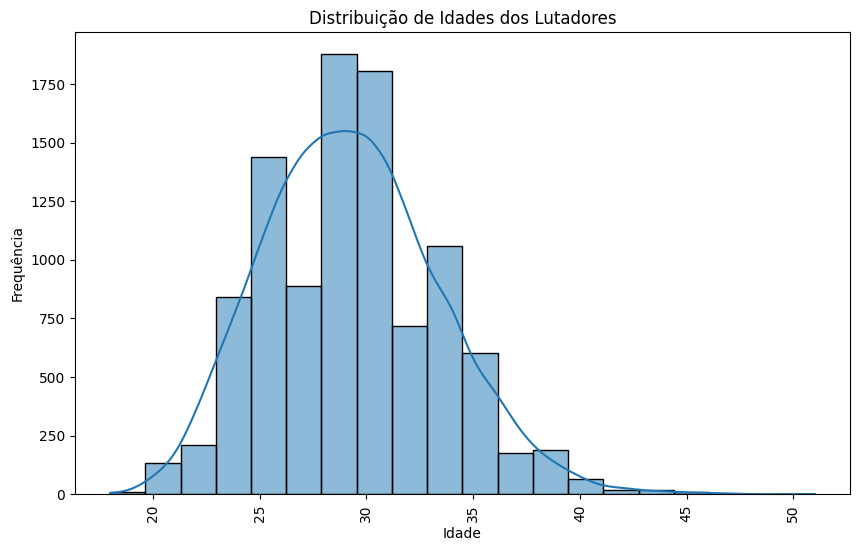

In [ ]:
total = np.concatenate((df_raw['R_age'].dropna().values, df_raw['B_age'].dropna().values))

plt.figure(figsize=(10, 6))
sns.histplot(total, bins=20, kde=True)
plt.xticks(rotation=90)
plt.xlabel("Idade")
plt.ylabel("Frequência")
plt.title("Distribuição de Idades dos Lutadores")
plt.show()

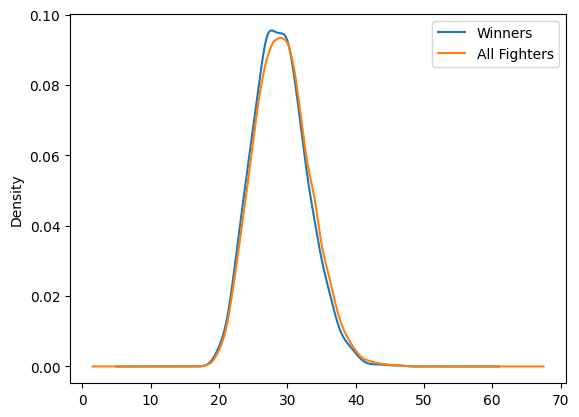

In [ ]:
df_raw['Winner_age'] = [b_age if winner == 'Blue' else r_age
                        for winner, b_age, r_age in
                        zip(df_raw['Winner'], df_raw['B_age'], df_raw['R_age'])]
ax = df_raw['Winner_age'].plot.kde();
pd.Series(total).plot.kde(ax=ax);
ax.legend(["Winners", "All Fighters"]);

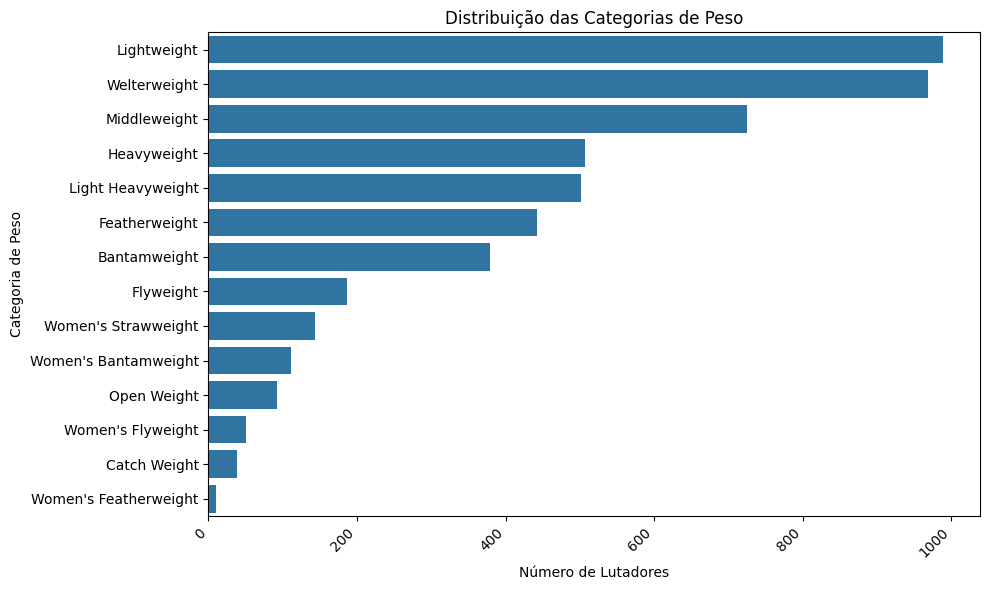

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

weight_counts = df_raw['weight_class'].value_counts()

plt.figure(figsize=(10, 6))
sns.countplot(y='weight_class', data=df_raw, order=weight_counts.index)
plt.title('Distribuição das Categorias de Peso')
plt.xlabel('Número de Lutadores')
plt.ylabel('Categoria de Peso')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
stance = df_raw[['Winner', 'B_Stance', 'R_Stance']].copy()
stance['Win_Stance'] = [b_stance if winner == 'Blue' and pd.notna(b_stance) else r_stance if pd.notna(r_stance) else None
                        for winner, b_stance, r_stance in zip(stance['Winner'], stance['B_Stance'], stance['R_Stance'])]
stance['Lose_Stance'] = [r_stance if winner == 'Blue' and pd.notna(r_stance) else b_stance if pd.notna(b_stance) else None
                         for winner, b_stance, r_stance in zip(stance['Winner'], stance['B_Stance'], stance['R_Stance'])]
stance.head()


,Winner,B_Stance,R_Stance,Win_Stance,Lose_Stance
0,Red,Orthodox,Orthodox,Orthodox,Orthodox
1,Red,Orthodox,Southpaw,Southpaw,Orthodox
2,Red,Orthodox,Orthodox,Orthodox,Orthodox
3,Blue,Switch,Orthodox,Switch,Orthodox
4,Blue,Southpaw,Southpaw,Southpaw,Southpaw


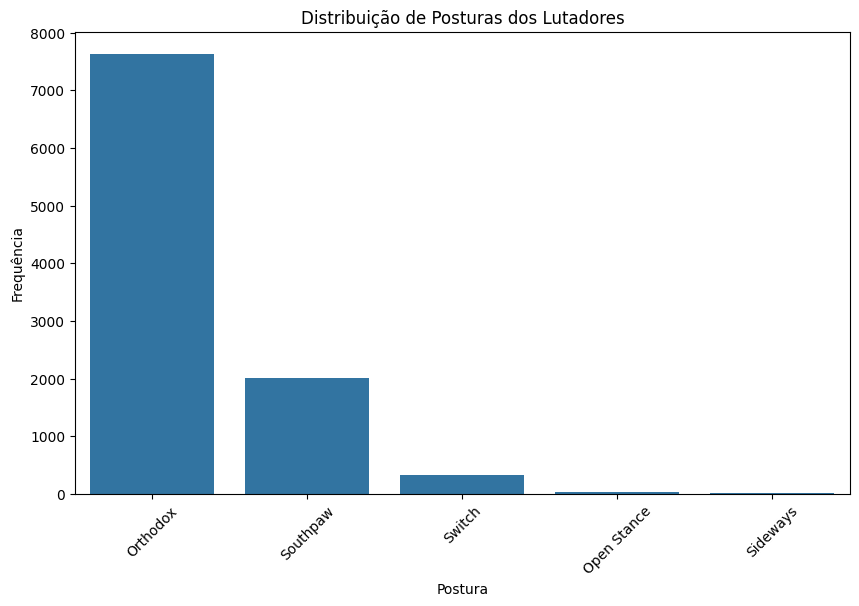

In [ ]:
stances = pd.DataFrame({'Stance': np.concatenate((df_raw['R_Stance'].values, df_raw['B_Stance'].values))})

plt.figure(figsize=(10, 6))
sns.countplot(data=stances, x='Stance', order=stances['Stance'].value_counts().index)
plt.xticks(rotation=45)
plt.xlabel("Postura")
plt.ylabel("Frequência")
plt.title("Distribuição de Posturas dos Lutadores")
plt.show()


<ipython-input-21-0ea39964a223>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Postura_Vencedora', data=postura, palette='Dark2')


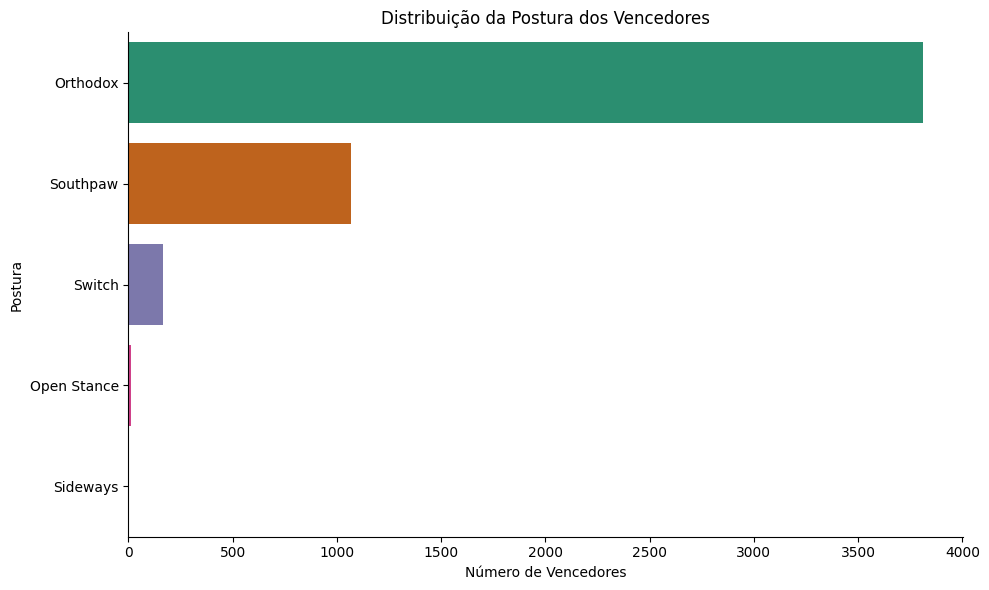

<ipython-input-21-0ea39964a223>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='weight_class', data=df_raw, order=weight_counts.index, palette='viridis')


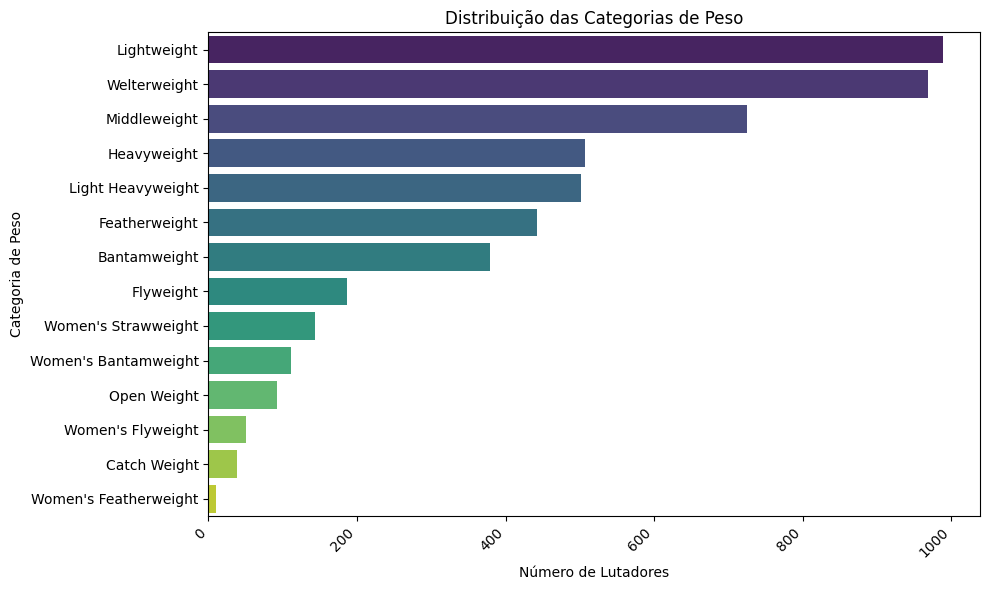

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_raw = pd.read_csv("/content/drive/MyDrive/IA/base de dados/data.csv")

postura = df_raw[['Winner', 'B_Stance', 'R_Stance']].copy()
postura['Postura_Vencedora'] = [b_stance if winner == 'Blue' and pd.notna(b_stance) else r_stance if pd.notna(r_stance) else None
                               for winner, b_stance, r_stance in zip(postura['Winner'], postura['B_Stance'], postura['R_Stance'])]
plt.figure(figsize=(10, 6))
sns.countplot(y='Postura_Vencedora', data=postura, palette='Dark2')
plt.title('Distribuição da Postura dos Vencedores')
plt.xlabel('Número de Vencedores')
plt.ylabel('Postura')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

weight_counts = df_raw['weight_class'].value_counts()
plt.figure(figsize=(10, 6))
sns.countplot(y='weight_class', data=df_raw, order=weight_counts.index, palette='viridis')
plt.title('Distribuição das Categorias de Peso')
plt.xlabel('Número de Lutadores')
plt.ylabel('Categoria de Peso')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Frequência')

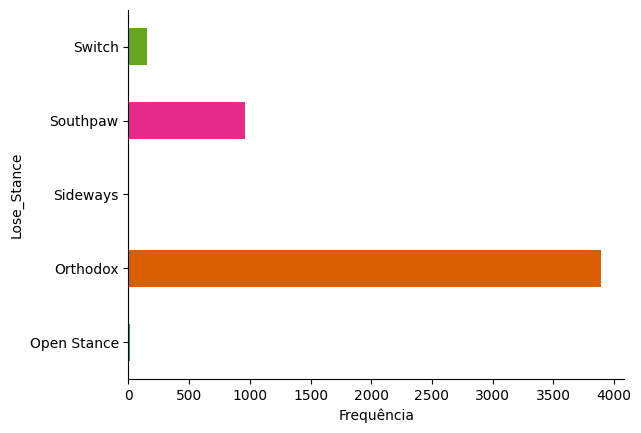

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

stance.groupby('Lose_Stance').size().plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Frequência')

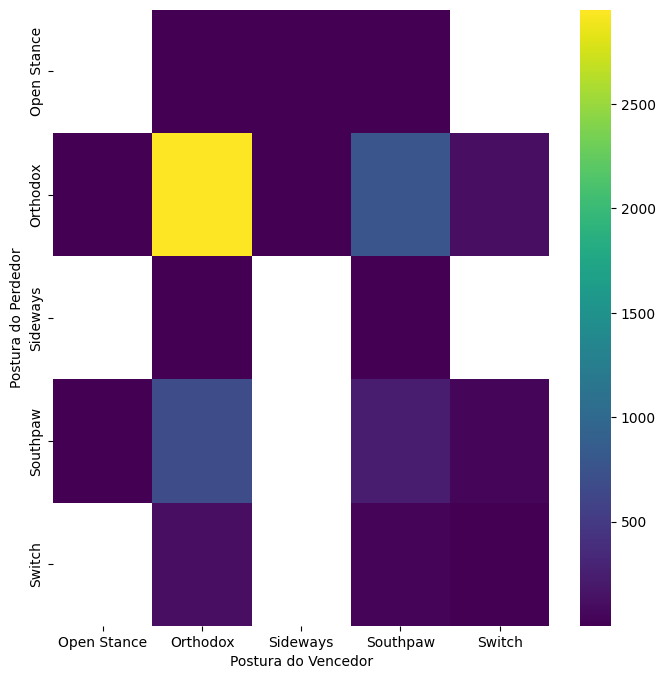

In [ ]:
# @title Postura do Vencedor vs Postura do Perdedor

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Configura o tamanho da figura
plt.subplots(figsize=(8, 8))

# Cria um DataFrame com as contagens de "Postura do Perdedor" para cada "Postura do Vencedor"
df_2dhist = pd.DataFrame({
    rótulo_x: grp['Lose_Stance'].value_counts()
    for rótulo_x, grp in stance.groupby('Win_Stance')
})

# Plota o gráfico de calor (heatmap)
sns.heatmap(df_2dhist, cmap='viridis')

# Define o rótulo do eixo X
plt.xlabel('Postura do Vencedor')

# Define o rótulo do eixo Y
_ = plt.ylabel('Postura do Perdedor')

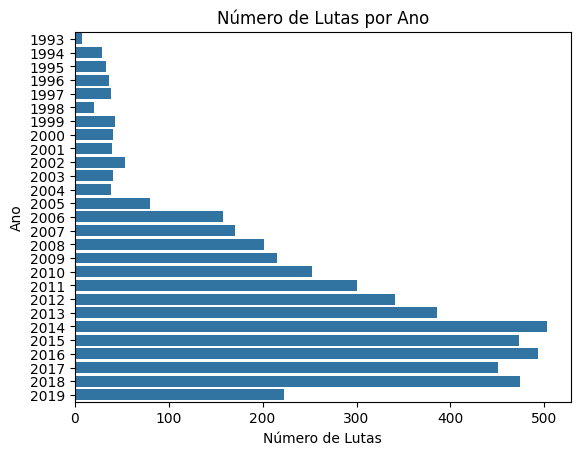

In [ ]:
df_raw['data'] = pd.to_datetime(df_raw['date'])
df_raw['ano'] = df_raw['data'].dt.year

plt.yticks(rotation=0)
sns.countplot(y=df_raw['ano'], data=df_raw)
plt.xlabel("Número de Lutas")
plt.ylabel("Ano")
plt.title("Número de Lutas por Ano")
plt.show()

In [ ]:
import pandas as pd

df_geo = df_raw[['date', 'location']].copy()

def get_lat_long(location):
  if location == "Las Vegas, Nevada, USA":
    return 36.1699, -115.1398
  elif location == "Newark, New Jersey, USA":
    return 40.7357, -74.1724
  else:
    return None, None
df_geo['Lat'], df_geo['Long'] = zip(*df_geo['location'].apply(get_lat_long))
df_geo


,date,location,Lat,Long
0,2019-06-08,"Chicago, Illinois, USA",NaN,NaN
1,2019-06-08,"Chicago, Illinois, USA",NaN,NaN
2,2019-06-08,"Chicago, Illinois, USA",NaN,NaN
3,2019-06-08,"Chicago, Illinois, USA",NaN,NaN
4,2019-06-08,"Chicago, Illinois, USA",NaN,NaN
...,...,...,...,...
5139,1993-11-12,"Denver, Colorado, USA",NaN,NaN
5140,1993-11-12,"Denver, Colorado, USA",NaN,NaN
5141,1993-11-12,"Denver, Colorado, USA",NaN,NaN
5142,1993-11-12,"Denver, Colorado, USA",NaN,NaN


<ipython-input-26-cda67bf9f432>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_geo['Country'], data=df_geo, palette='viridis');


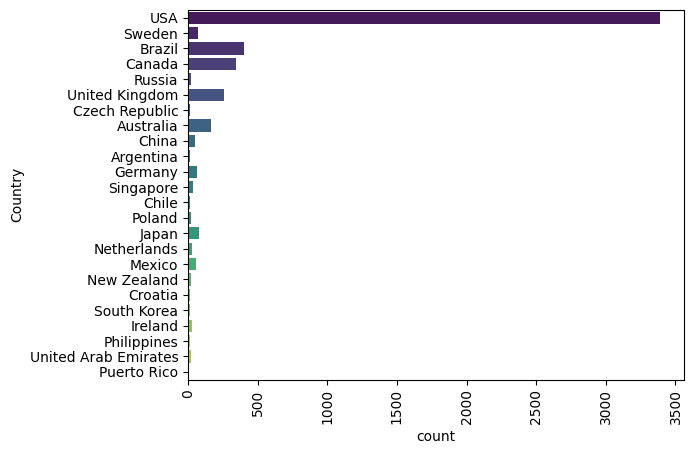

In [ ]:
for index, row in df_geo.iterrows():
    parts = row['location'].split(',')
    df_geo.loc[index, 'Country'] = parts[-1].strip()
    df_geo.loc[index, 'City'] = parts[0].strip()
    if len(parts) == 3:
        df_geo.loc[index, 'State'] = parts[1].strip()
plt.xticks(rotation=90)
sns.countplot(y=df_geo['Country'], data=df_geo, palette='viridis');



Preparar os Dados

1. existe valor ausente?
2.tratamento de valores ausentes precisam utilizar média de treinamento

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
features = ['R_age', 'B_age', 'R_Height_cms', 'B_Height_cms', 'R_Reach_cms', 'B_Reach_cms',  'R_win_by_Decision_Majority', 'B_win_by_Decision_Majority', 'R_win_by_Decision_Split', 'B_win_by_Decision_Split', 'R_win_by_Decision_Unanimous', 'B_win_by_Decision_Unanimous', 'R_win_by_KO/TKO', 'B_win_by_KO/TKO', 'R_win_by_Submission', 'B_win_by_Submission', 'R_win_by_TKO_Doctor_Stoppage', 'B_win_by_TKO_Doctor_Stoppage']
target = 'Winner'

In [ ]:
for feature in features:
    df[feature] = df[feature].fillna(df[feature].mean())

In [ ]:
df.isnull().sum()

,0
Winner,0
title_bout,0
no_of_rounds,0
B_current_lose_streak,0
B_current_win_streak,0
...,...
B_Stance_Switch,0
R_Stance_Open Stance,0
R_Stance_Orthodox,0
R_Stance_Southpaw,0


In [ ]:
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

1. pesquisar e aplicar o gridsearchCV para cada modelo

2. calcular o desempenho de cada modelo em treinamento e teste.

Desempenho dos Modelos

KNN


In [ ]:
knn = KNeighborsClassifier()

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance']
}


grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)
print("Melhores hiperparâmetros para KNN:", grid_search_knn.best_params_)


Melhores hiperparâmetros para KNN: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}


In [ ]:
y_train_pred_knn = grid_search_knn.predict(X_train)
y_test_pred_knn = grid_search_knn.predict(X_test)


train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)

print("KNN - Acurácia no Treinamento:", train_accuracy_knn)
print("KNN - Acurácia no Teste:", test_accuracy_knn)
print("KNN - Relatório de Classificação no Teste:\n", classification_report(y_test, y_test_pred_knn))


KNN - Acurácia no Treinamento: 1.0
KNN - Acurácia no Teste: 0.6689847009735744
KNN - Relatório de Classificação no Teste:
               precision    recall  f1-score   support

        Blue       0.46      0.21      0.29       230
         Red       0.70      0.89      0.78       489

    accuracy                           0.67       719
   macro avg       0.58      0.55      0.54       719
weighted avg       0.63      0.67      0.63       719



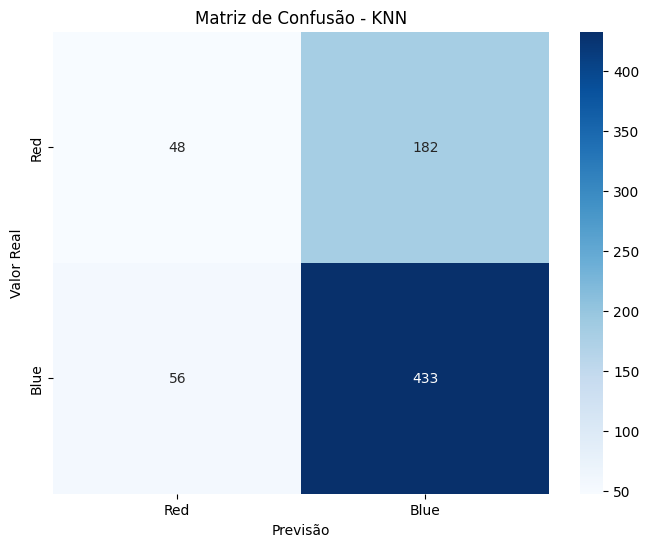

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm_knn = confusion_matrix(y_test, y_test_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Red', 'Blue'], yticklabels=['Red', 'Blue'])
plt.title('Matriz de Confusão - KNN')
plt.xlabel('Previsão')
plt.ylabel('Valor Real')
plt.show()

Árvore de decisão

In [ ]:
dt = DecisionTreeClassifier()
param_grid_dt = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)
print("Melhores hiperparâmetros para Árvore de Decisão:", grid_search_dt.best_params_)


Melhores hiperparâmetros para Árvore de Decisão: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 5}


GridSearchCV na Árvore de Decisão

In [ ]:
y_train_pred_dt = grid_search_dt.predict(X_train)
y_test_pred_dt = grid_search_dt.predict(X_test)
train_accuracy_dt = accuracy_score(y_train, y_train_pred_dt)
test_accuracy_dt = accuracy_score(y_test, y_test_pred_dt)
print("Árvore de Decisão - Acurácia no Treinamento:", train_accuracy_dt)
print("Árvore de Decisão - Acurácia no Teste:", test_accuracy_dt)
print("Árvore de Decisão - Relatório de Classificação no Teste:\n", classification_report(y_test, y_test_pred_dt))


Árvore de Decisão - Acurácia no Treinamento: 0.6592689295039165
Árvore de Decisão - Acurácia no Teste: 0.6815020862308763
Árvore de Decisão - Relatório de Classificação no Teste:
               precision    recall  f1-score   support

        Blue       1.00      0.00      0.01       230
         Red       0.68      1.00      0.81       489

    accuracy                           0.68       719
   macro avg       0.84      0.50      0.41       719
weighted avg       0.78      0.68      0.55       719



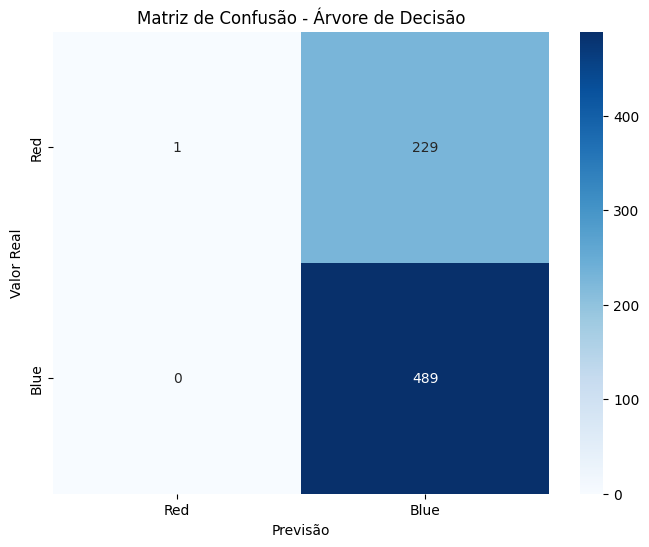

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm_dt = confusion_matrix(y_test, y_test_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Red', 'Blue'], yticklabels=['Red', 'Blue'])
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.xlabel('Previsão')
plt.ylabel('Valor Real')
plt.show()

MLP


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

features = ['R_age', 'B_age', 'R_Height_cms', 'B_Height_cms',
            'R_Reach_cms', 'B_Reach_cms', 'R_win_by_Decision_Majority',
            'B_win_by_Decision_Majority', 'R_win_by_Decision_Split',
            'B_win_by_Decision_Split', 'R_win_by_Decision_Unanimous',
            'B_win_by_Decision_Unanimous', 'R_win_by_KO/TKO',
            'B_win_by_KO/TKO', 'R_win_by_Submission', 'B_win_by_Submission',
            'R_win_by_TKO_Doctor_Stoppage', 'B_win_by_TKO_Doctor_Stoppage']
target = 'Winner'

X = df[features]
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


mlp = MLPClassifier(max_iter=500, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Acurácia no conjunto de teste:", grid_search.best_score_)

best_mlp = grid_search.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Melhores hiperparâmetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
Acurácia no conjunto de teste: 0.6675940009089532


GridSearchCV do MLP

In [ ]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

features = ['R_age', 'B_age', 'R_Height_cms', 'B_Height_cms',
            'R_Reach_cms', 'B_Reach_cms', 'R_win_by_Decision_Majority',
            'B_win_by_Decision_Majority', 'R_win_by_Decision_Split',
            'B_win_by_Decision_Split', 'R_win_by_Decision_Unanimous',
            'B_win_by_Decision_Unanimous', 'R_win_by_KO/TKO',
            'B_win_by_KO/TKO', 'R_win_by_Submission', 'B_win_by_Submission',
            'R_win_by_TKO_Doctor_Stoppage', 'B_win_by_TKO_Doctor_Stoppage']
target = 'Winner'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam',
                    alpha=0.0001, learning_rate='constant', random_state=42, max_iter=500)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy)

print(classification_report(y_test, y_pred))

Acurácia: 0.6662030598052852
              precision    recall  f1-score   support

        Blue       0.47      0.36      0.41       230
         Red       0.73      0.81      0.77       489

    accuracy                           0.67       719
   macro avg       0.60      0.58      0.59       719
weighted avg       0.65      0.67      0.65       719



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


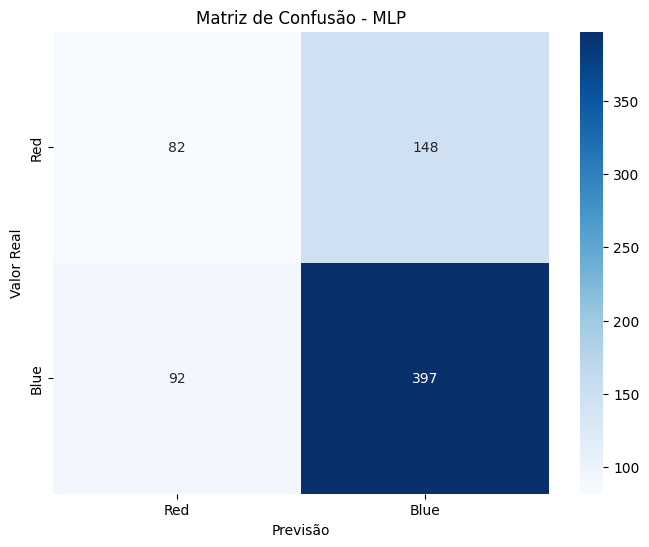

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm_mlp = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Red', 'Blue'], yticklabels=['Red', 'Blue'])
plt.title('Matriz de Confusão - MLP')
plt.xlabel('Previsão')
plt.ylabel('Valor Real')
plt.show()

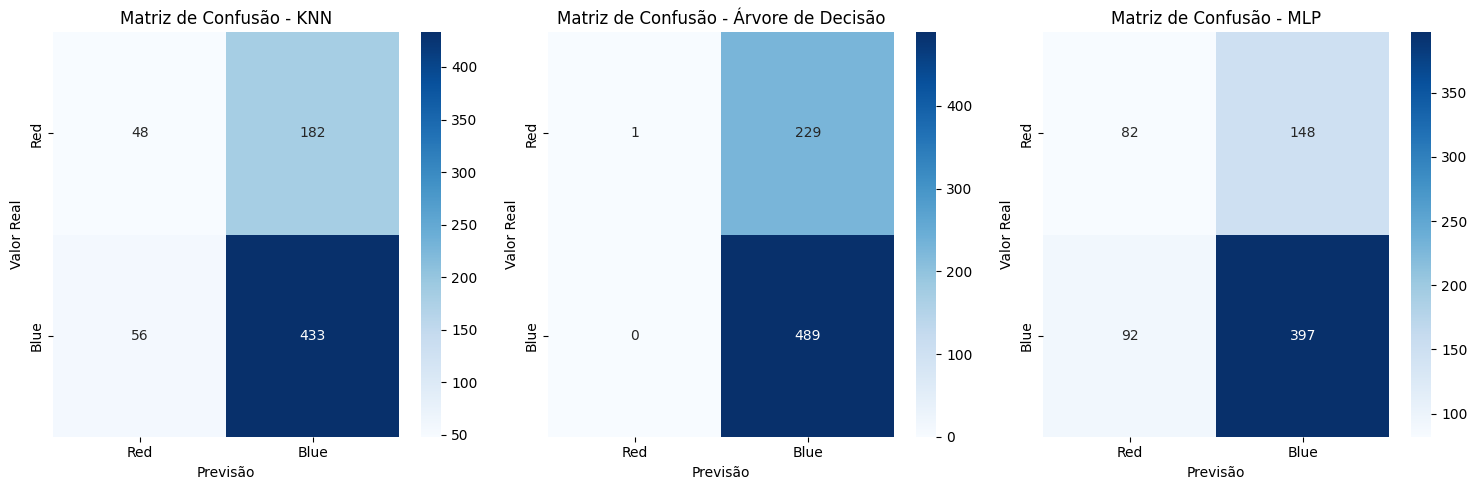

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_knn = confusion_matrix(y_test, y_test_pred_knn)
cm_dt = confusion_matrix(y_test, y_test_pred_dt)
cm_mlp = confusion_matrix(y_test, y_pred)

model_names = ['KNN', 'Árvore de Decisão', 'MLP']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, cm in enumerate([cm_knn, cm_dt, cm_mlp]):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i],
                xticklabels=['Red', 'Blue'], yticklabels=['Red', 'Blue'])
    axes[i].set_title(f'Matriz de Confusão - {model_names[i]}')
    axes[i].set_xlabel('Previsão')
    axes[i].set_ylabel('Valor Real')

plt.tight_layout()
plt.show()